<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/Personal_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install yfinance
!pip install quandl

In [0]:
import pandas as pd
import numpy as np

import yfinance as yf
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
positions = pd.DataFrame({
    'TICKER':['MCD','T','PFE'],
    'BUY DATE':['2019-10-29','2019-11-09','2019-12-02'],
    'BUY PRICE':[192.78,39.76,38.37],
    'POSITION':[0.3898,2.015,1.9672]
})
positions['BUY DATE'] = pd.to_datetime(positions['BUY DATE'])
positions

,TICKER,BUY DATE,BUY PRICE,POSITION
0,MCD,2019-10-29,192.78,0.3898
1,T,2019-11-09,39.76,2.0150
2,PFE,2019-12-02,38.37,1.9672


[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


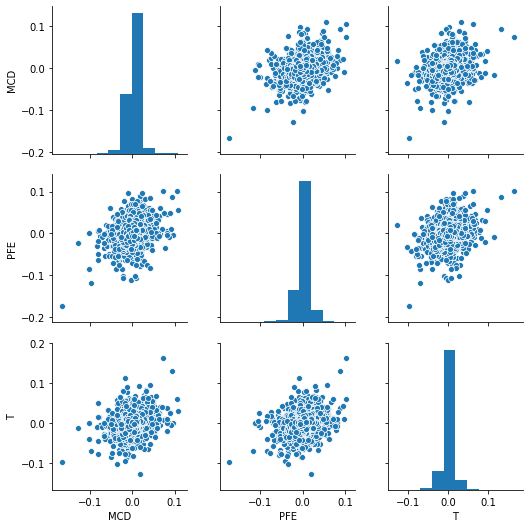

In [0]:
data = yf.download(positions['TICKER'].to_list()).resample('D').pad()
prices = data['Close'].fillna(method='ffill')

vixData = yf.download('^VIX').resample('D').pad()
vixPrices = vixData['Close'].fillna(method='ffill')

eeeData = yf.download('CEC.DE').resample('D').pad()
eee = eeeData['Close'].fillna(method='ffill')

#positions['BUY PRICE'] = 0.0
positions['MV'] = 0.0

ret = prices.pct_change().dropna()
wret = prices.pct_change(7).dropna()
mret = prices.pct_change(28).dropna()

log_ret = np.log(prices/prices.shift()).dropna()
mlog_ret = log_ret.rolling(28).sum()

sns.pairplot(ret)
plt.show();

In [0]:
for i in positions.index:
    ticker = positions.loc[i, 'TICKER']
    buyDate = positions.loc[i, 'BUY DATE']

    #positions.loc[i, 'BUY PRICE'] = prices.loc[buyDate, ticker]
    positions.loc[i, 'MV'] = positions.loc[i, 'POSITION'] * prices.iloc[-1][ticker]
#need to add div stats: yield, 5y avg yield, div growth years, expected div payment, div payment month
positions['WEIGHT'] = positions['MV']/positions['MV'].sum()
positions['RET'] = positions['MV'].div(positions['BUY PRICE'].mul(positions['POSITION'])).add(-1.0)

print('\nAUM: EUR',
      round(positions['MV'].sum(),2))

totalRet = positions['MV'].sum()/(positions['BUY PRICE'].mul(positions['POSITION']).sum()) - 1.
print('Total return: {}%'.format(round(100*totalRet,3)))
print('Expected 1Y return: {}%\n'.format(round(100*(np.dot(positions['WEIGHT'], 
                                                           log_ret.mean()[positions['TICKER']]) * 365),3)))

positions


AUM: EUR 229.33
Total return: -0.611%
Expected 1Y return: 8.742%



,TICKER,BUY DATE,BUY PRICE,POSITION,MV,WEIGHT,RET
0,MCD,2019-10-29,192.78,0.3898,76.837374,0.335046,0.022513
1,T,2019-11-09,39.76,2.0150,77.093897,0.336164,-0.037726
2,PFE,2019-12-02,38.37,1.9672,75.402780,0.328790,-0.001042


In [0]:
tickers = positions['TICKER'].to_list()
weights = positions['WEIGHT']
covar = ret[tickers].cov()
portSeries = pd.Series(np.dot(mret[tickers], weights), index=mret.index).dropna()

In [0]:
portRet = np.dot(ret[tickers].mean(), weights)*365
portRisk = np.sqrt(np.dot(weights.T, np.dot(covar, weights))) * np.sqrt(365)
portVaR = portSeries.quantile(q=0.01)
portDTrisk = portSeries[portSeries < 0.0].std() * np.sqrt(12)

print('VaR (1%): {}%'.format(round(100*portVaR,3)))
print('Return: {}%'.format(round(100*portRet,3)))
print('Risk: {}%'.format(round(100*portRisk, 3)))
print('Downturn risk: {}%'.format(round(100*portDTrisk,3)))
print('Return/Risk:', round(portRet/portRisk,3))

VaR (1%): -11.95%
Return: 11.909%
Risk: 18.537%
Downturn risk: 10.797%
Return/Risk: 0.642


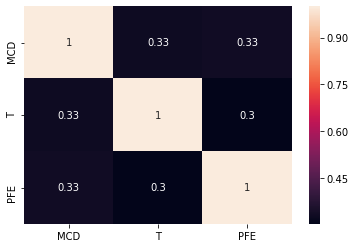

In [0]:
sns.heatmap(mret[tickers].corr(method='pearson'), annot=True)
plt.show();

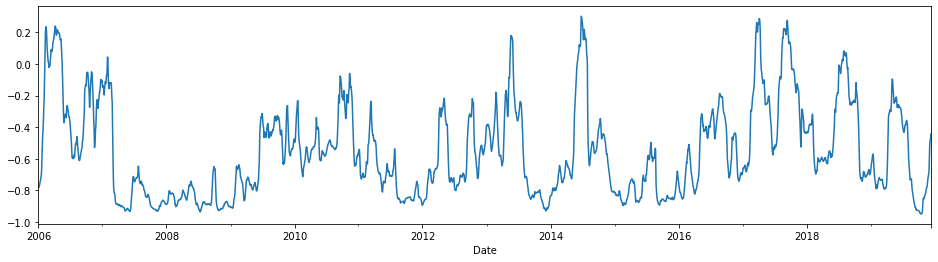

Correlation with VIX: -0.439
Expected 1Y return: 7.81%
Expected 1M return: 1.0% (3.53% STD, -212.19 Beta)



/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,RET,STD,Beta,PROB
-5,0.010362,0.035157,-2.738506,0.368713
-4,0.010419,0.035877,-2.273739,0.339010
-3,0.009162,0.034773,-1.167823,0.292277


In [0]:
vixCorr = vixPrices.pct_change(28).rolling(100).corr(portSeries).dropna()
vixCorr['2006':].plot(figsize=(16,4))
plt.show();

lower = -1.0
upper = 1.0

expOutcome = pd.DataFrame(index=list(range(-10,10)))
expOutcome['RET'] = 0.0
expOutcome['STD'] = 0.0
expOutcome['Beta'] = 0.0
expOutcome['PROB'] = 0.0

for i in range(-10,10):
    lower = i/10
    upper = lower + 0.1

    perRet = portSeries.loc[vixCorr[np.logical_and(vixCorr <= upper, vixCorr > lower)].index]
    vixRet = vixPrices.pct_change(28).loc[vixCorr[np.logical_and(vixCorr <= upper, vixCorr > lower)].index]

    expOutcome.loc[i, 'RET'] = perRet.mean()
    expOutcome.loc[i, 'STD'] = perRet.std()
    expOutcome.loc[i, 'Beta'] = float(np.cov(perRet, vixRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'PROB'] = len(perRet)/len(portSeries)    

print('Correlation with VIX:', round(vixPrices.pct_change(28).corr(portSeries),3))
expOutcome = expOutcome.fillna(0.0)

currState = int(vixCorr.iloc[-1]*10)
cSt = expOutcome.loc[[currState-1,currState,currState+1]]
cSt['PROB'] = cSt['PROB']/cSt['PROB'].sum()

print('Expected 1Y return: {}%'.format(round(100*expOutcome['RET'].mul(expOutcome['PROB']).sum()*12,2)))
print('Expected 1M return: {}% ({}% STD, {} Beta)\n'.format(round(100*cSt['RET'].mul(cSt['PROB']).sum(),2),
                                                          round(100*cSt['STD'].mul(cSt['PROB']).sum(),2),
                                                          round(100*cSt['Beta'].mul(cSt['PROB']).sum(),2)))
cSt

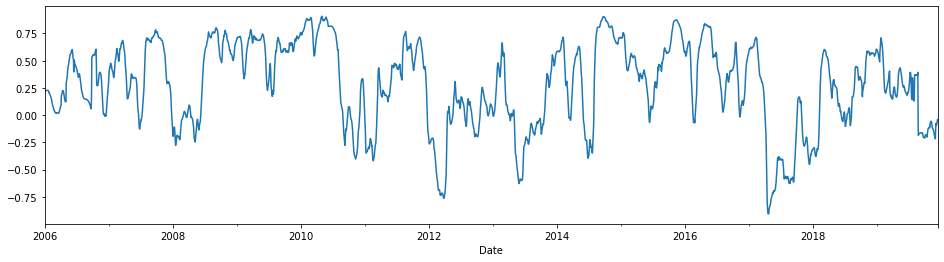

Correlation with Eastern Europe: 0.118
Expected 1Y return: 2.82%
Expected 1M return: 0.34% (4.17% STD, 40.24 Beta)



,RET,STD,Beta,PROB
-1,0.003993,0.034867,0.103314,0.257518
0,0.000437,0.043286,0.713816,0.374418
1,0.005963,0.044992,0.294881,0.368064


In [0]:
eeeCorr = eee.pct_change(28).rolling(100).corr(portSeries).dropna()
eeeCorr['2006':].plot(figsize=(16,4))
plt.show();

lower = -1.0
upper = 1.0

expOutcome = pd.DataFrame(index=list(range(-10,10)))
expOutcome['RET'] = 0.0
expOutcome['STD'] = 0.0
expOutcome['Beta'] = 0.0
expOutcome['PROB'] = 0.0

for i in range(-10,10):
    lower = i/10
    upper = lower + 0.1

    perRet = portSeries.loc[eeeCorr[np.logical_and(eeeCorr <= upper, eeeCorr > lower)].index]
    eeeRet = eee.pct_change(28).loc[eeeCorr[np.logical_and(eeeCorr <= upper, eeeCorr > lower)].index]

    expOutcome.loc[i, 'RET'] = perRet.mean()
    expOutcome.loc[i, 'STD'] = perRet.std()
    expOutcome.loc[i, 'Beta'] = float(np.cov(perRet, eeeRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'PROB'] = len(perRet)/len(portSeries)    

print('Correlation with Eastern Europe:', round(eee.pct_change(28).corr(portSeries),3))
expOutcome = expOutcome.fillna(0.0)

currState = int(eeeCorr.iloc[-1]*10)
cSt = expOutcome.loc[[currState-1,currState,currState+1]]
cSt['PROB'] = cSt['PROB']/cSt['PROB'].sum()

print('Expected 1Y return: {}%'.format(round(100*expOutcome['RET'].mul(expOutcome['PROB']).sum()*12,2)))
print('Expected 1M return: {}% ({}% STD, {} Beta)\n'.format(round(100*cSt['RET'].mul(cSt['PROB']).sum(),2),
                                                          round(100*cSt['STD'].mul(cSt['PROB']).sum(),2),
                                                          round(100*cSt['Beta'].mul(cSt['PROB']).sum(),2)))
cSt

In [0]:
expOutcome = pd.DataFrame(index=list(range(0,100,10)))
expOutcome['RET'] = 0.0
expOutcome['STD'] = 0.0
expOutcome['Beta EEE'] = 0.0
expOutcome['Beta VIX'] = 0.0
expOutcome['PROB'] = 0.0

stdRoll = portSeries.rolling(28).std()

for i in range(0,100,10):
    lower = i/100
    upper = lower + 0.1

    perRet = portSeries.loc[stdRoll[np.logical_and(stdRoll <= stdRoll.quantile(upper), stdRoll > stdRoll.quantile(lower))].index]
    eeeRet = eee.pct_change(28).loc[perRet.index]
    vixRet = vixPrices.pct_change(28).loc[perRet.index]

    expOutcome.loc[i, 'RET'] = perRet.mean()
    expOutcome.loc[i, 'STD'] = perRet.std()
    expOutcome.loc[i, 'Beta EEE'] = float(np.cov(perRet, eeeRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'Beta VIX'] = float(np.cov(perRet, vixRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'PROB'] = len(perRet)/len(portSeries)    

print('Correlation with Eastern Europe:', round(eee.pct_change(28).corr(portSeries),3))
expOutcome = expOutcome.fillna(0.0)

currState = int(eeeCorr.iloc[-1]*10)
cSt = expOutcome.loc[[currState-1,currState,currState+1]]
cSt['PROB'] = cSt['PROB']/cSt['PROB'].sum()

print('Expected 1Y return: {}%'.format(round(100*expOutcome['RET'].mul(expOutcome['PROB']).sum()*12,2)))
print('Expected 1M return: {}% ({}% STD)'.format(round(100*cSt['RET'].mul(cSt['PROB']).sum(),2),
                                                 round(100*cSt['STD'].mul(cSt['PROB']).sum(),2)))

print('Beta Europe: {}%\nBeta VIX: {}%\n'.format(round(100*cSt['Beta EEE'].mul(cSt['PROB']).sum(),2), 
                                                round(100*cSt['Beta VIX'].mul(cSt['PROB']).sum(),2)))
cSt
expOutcome

Correlation with Eastern Europe: 0.118
Expected 1Y return: 10.44%
Expected 1M return: 0.98% (2.16% STD)
Beta Europe: 0.0%
Beta VIX: 0.0%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:


,RET,STD,Beta EEE,Beta VIX,PROB
0,0.009769,0.021568,0.0,0.0,0.099741
10,0.011306,0.025862,0.0,0.0,0.099817
20,0.009066,0.029833,0.0,0.0,0.099741
30,0.011191,0.032793,0.0,0.0,0.099817
40,0.009031,0.036567,0.0,0.0,0.099817
50,0.004910,0.039868,0.0,0.0,0.099741
60,0.007778,0.042950,0.0,0.0,0.099817
70,0.008153,0.047377,0.0,0.0,0.099741
80,0.011674,0.055213,0.0,0.0,0.099817
90,0.004308,0.086372,0.0,0.0,0.099817


In [0]:
expOutcome = pd.DataFrame(index=list(range(0,100,10)))
expOutcome['RET'] = 0.0
expOutcome['STD'] = 0.0
expOutcome['Beta EEE'] = 0.0
expOutcome['Beta VIX'] = 0.0
expOutcome['PROB'] = 0.0

corRoll = portSeries.rolling(28).corr(portSeries.shift(28))

for i in range(0,100,10):
    lower = i/100
    upper = lower + 0.1

    perRet = portSeries.loc[corRoll[np.logical_and(corRoll <= corRoll.quantile(upper), corRoll > corRoll.quantile(lower))].index]
    eeeRet = eee.pct_change(28).loc[perRet.index]
    vixRet = vixPrices.pct_change(28).loc[perRet.index]

    expOutcome.loc[i, 'RET'] = perRet.mean()
    expOutcome.loc[i, 'STD'] = perRet.std()
    expOutcome.loc[i, 'Beta EEE'] = float(np.cov(perRet, eeeRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'Beta VIX'] = float(np.cov(perRet, vixRet)[0][1])/perRet.var()
    expOutcome.loc[i, 'PROB'] = len(perRet)/len(portSeries)    

print('Correlation with Eastern Europe:', round(eee.pct_change(28).corr(portSeries),3))
expOutcome = expOutcome.fillna(0.0)

currState = int(eeeCorr.iloc[-1]*10)
cSt = expOutcome.loc[[currState-1,currState,currState+1]]
cSt['PROB'] = cSt['PROB']/cSt['PROB'].sum()

print('Expected 1Y return: {}%'.format(round(100*expOutcome['RET'].mul(expOutcome['PROB']).sum()*12,2)))
print('Expected 1M return: {}% ({}% STD)'.format(round(100*cSt['RET'].mul(cSt['PROB']).sum(),2),
                                                 round(100*cSt['STD'].mul(cSt['PROB']).sum(),2)))

print('Beta Europe: {}%\nBeta VIX: {}%\n'.format(round(100*cSt['Beta EEE'].mul(cSt['PROB']).sum(),2), 
                                                round(100*cSt['Beta VIX'].mul(cSt['PROB']).sum(),2)))
cSt
expOutcome

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()


Correlation with Eastern Europe: 0.118
Expected 1Y return: 10.42%
Expected 1M return: 1.05% (4.89% STD)
Beta Europe: 0.0%
Beta VIX: 0.0%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,RET,STD,Beta EEE,Beta VIX,PROB
0,0.010510,0.048872,0.0,0.0,0.099513
10,0.009578,0.045283,0.0,0.0,0.099589
20,0.009732,0.039975,0.0,0.0,0.099589
30,0.008321,0.041207,0.0,0.0,0.099589
40,0.007821,0.043813,0.0,0.0,0.099589
50,0.007207,0.040618,0.0,0.0,0.099513
60,0.008728,0.040991,0.0,0.0,0.099589
70,0.012506,0.045513,0.0,0.0,0.099589
80,0.010180,0.046936,0.0,0.0,0.099589
90,0.002630,0.058205,0.0,0.0,0.099589
